##State-Farm-Distracted-Driver-Detection
##Data augmentation 

##import libraries

In [1]:
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
import os  
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense,Flatten, Dropout
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import SGD, Adam

##load data

In [2]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle (6).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                           Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          15403        449  1.0              
ruchi798/data-science-job-salaries                                 Data Science Job Salaries                             7KB  2022-06-15 08:59:12           4087        144  1.0              
zusmani/petrolgas-prices-worldwide                                 Petrol/Gas Prices Worldwide                          10KB  2022-06-24 0

In [3]:
! kaggle competitions download -c state-farm-distracted-driver-detection

state-farm-distracted-driver-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
! unzip /content/state-farm-distracted-driver-detection.zip

Archive:  /content/state-farm-distracted-driver-detection.zip
replace driver_imgs_list.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Preprocessing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def preparData(path):
  imagsList = []
  labels = []
  for dic in sorted(glob.glob(os.path.join(path,'*')), key = lambda k: k.split('/')[-1]):
    for imgs in glob.glob(os.path.join(dic, '*.jpg')):
      img = cv2.imread(imgs)
      img_r = cv2.resize(img,(128,128))
      imagsList.append(img_r)
      labels.append(int(dic.split("/")[-1].replace('c','')))
  
  X_train, X_test, y_train, y_test = train_test_split(imagsList, labels, test_size=0.2,shuffle= True, random_state = 0)
  y_train = to_categorical(y_train)
  y_test  = to_categorical(y_test)

  return np.array(X_train), np.array(X_test), y_train, y_test


In [6]:
path_train = "/content/imgs/train/"
path_test  = "/content/imgs/test/"

X_train, X_test, y_train, y_test = preparData(path_train)

#shapes of traning and testing
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (17939, 128, 128, 3)
y_train shape: (17939, 10)
X_test shape:  (4485, 128, 128, 3)
y_test shape:  (4485, 10)


##Visualize examples of data

##classes :
        c0: Safe driving 
        c1: Texting - right 
        c2: Talking on the phone - right 
        c3: Texting - left
        c4: Talking on the phone - left
        c5: Operating the radio
        c6: Drinking
        c7: Reaching behind 
        c8: Hair and makeup 
        c9: Talking to passenger

(128, 128, 3)


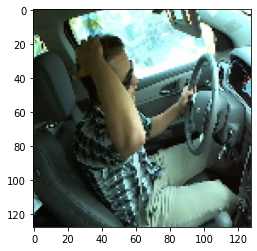

In [ ]:
print(X_train[902].shape)
img = X_train[902]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print(f"Class: {y_train[902]}")

##3- Data augmentation

In [7]:
datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

datagen.fit(X_train)

##visualize example of augmentation

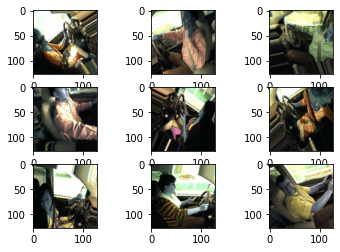

In [8]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=50):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

##scaling data

In [8]:
#scaling daa
X_test = X_test.astype('float32')/255

In [9]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=None, input_shape=(128, 128, 3),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=None,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0))
model.add(Conv2D(2*32, (3, 3), activation='relu',kernel_regularizer=None,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*32, (3, 3), activation='relu',kernel_regularizer=None,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0))
model.add(Conv2D(4*32, (3, 3), activation='relu',kernel_regularizer=None,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*32, (3, 3), activation='relu',kernel_regularizer=None,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0))
model.add(Flatten())
model.add(Dense(512, activation='relu',kernel_regularizer=None))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                        

In [11]:
from keras import optimizers
from keras.regularizers import l2
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
history=model.fit(datagen.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch = len(X_train) / 128, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
140/140 [==============================] - 88s 519ms/step - loss: 2.5922 - accuracy: 0.1834 - val_loss: 17.2691 - val_accuracy: 0.1066
Epoch 2/20
140/140 [==============================] - 71s 508ms/step - loss: 1.8153 - accuracy: 0.3648 - val_loss: 3.6096 - val_accuracy: 0.1055
Epoch 3/20
140/140 [==============================] - 70s 501ms/step - loss: 1.3275 - accuracy: 0.5344 - val_loss: 2.3957 - val_accuracy: 0.2303
Epoch 4/20
140/140 [==============================] - 71s 509ms/step - loss: 0.9347 - accuracy: 0.6808 - val_loss: 1.6716 - val_accuracy: 0.4834
Epoch 5/20
140/140 [==============================] - 71s 503ms/step - loss: 0.6630 - accuracy: 0.7800 - val_loss: 0.5895 - val_accuracy: 0.7933
Epoch 6/20
140/140 [==============================] - 75s 535ms/step - loss: 0.5054 - accuracy: 0.8340 - val_loss: 0.8442 - val_accuracy: 0.7313
Epoch 7/20
140/140 [==============================] - 74s 524ms/step - loss: 0.4110 - accuracy: 0.8684 - val_loss: 0.8794 - val_a

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

##Analysis result 

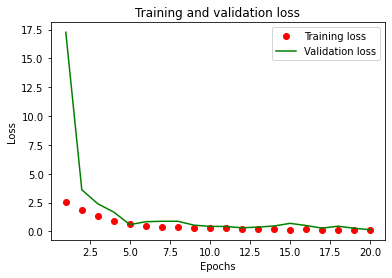

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

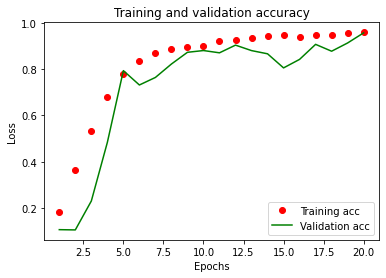

In [15]:
#clear figure
plt.clf()   
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

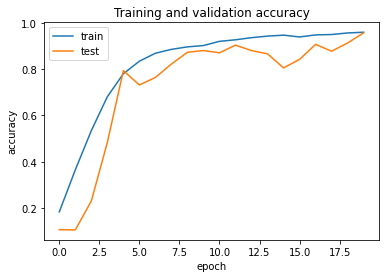

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()

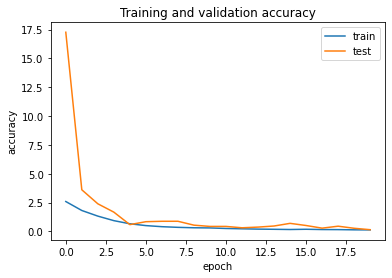

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()